# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [628]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

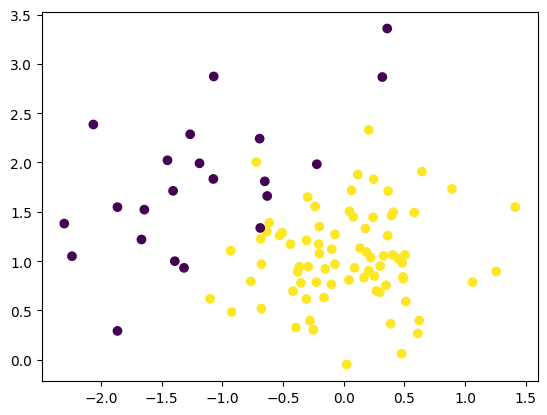

In [629]:
import numpy as np
import matplotlib.pyplot as plt 
# load the training set 
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
plt.scatter(x_train[:,0],x_train[:,1],c=class_train)
plt.show()

In [630]:
# load the test set
test = np.loadtxt('data/synth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


**Answer:**

In [663]:
import bottleneck as bn
# def distance (x,y) :
#     return np.linalg.norm(x-y, axis=1)

def knn (x_test,class_train,x_train,n_neighbours) : 
    
    N_test = x_test.shape[0]
    # distances = np.zeros((N_test,N_train))
    class_pred = np.zeros(N_test, dtype=int)
    for i in range(N_test) : 
        distances = np.linalg.norm(x_test[i,np.newaxis]-x_train, axis=1) 
        id = np.argsort(distances)[:n_neighbours] #les indices des n_neighbours les plus proches
        labels = class_train[id]
        # Count occurrences of each class label in the nearest neighbors
        label_counts = np.bincount(labels.astype(int))
        # Select the class with the highest occurrence
        class_pred[i] = np.argmax(label_counts)
    
    return class_pred

def knn_bn (x_test,class_train,x_train,n_neighbours) : 
    N_test = x_test.shape[0]
    # distances = np.zeros((N_test,N_train))
    class_pred = np.zeros(N_test, dtype=int)
    for i in range(N_test) : 
        distances = np.linalg.norm(x_test[i,np.newaxis]-x_train, axis=1) 
        # id = np.argsort(distances)[:n_neighbours] #les indices des n_neighbours les plus proches
        id = bn.argpartition(distances,n_neighbours)[:n_neighbours]
        labels = class_train[id]
        # Count occurrences of each class label in the nearest neighbors
        label_counts = np.bincount(labels.astype(int))
        # Select the class with the highest occurrence
        class_pred[i] = np.argmax(label_counts)
    
    return class_pred
"""we get the predicted class by returning the index of the maximum occurence"""

'we get the predicted class by returning the index of the maximum occurence'

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

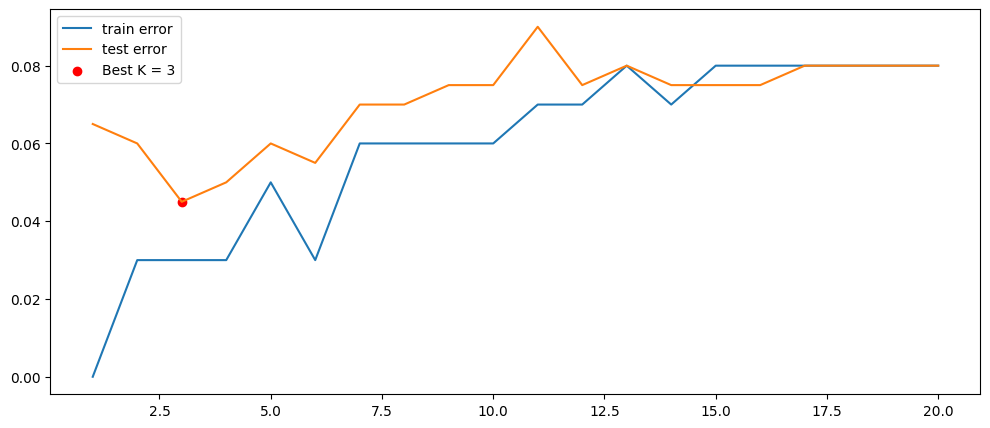

In [632]:
k_pos = np.arange(1,21)
error_train = np.zeros((len(k_pos)))
error_test = np.zeros((len(k_pos)))
error_inf = np.inf
best_k_test = 1

for k in k_pos : 
    class_pred_train = knn (x_train,class_train, x_train, k)
    error_train[k-1] = np.mean(class_train.astype(int) != class_pred_train)

    class_pred_test = knn (x_test, class_train,x_train, k)
    error_test[k-1] = np.mean(test[:,0].astype(int) != class_pred_test)
    if error_test[k-1].astype(float) < error_inf : #trouver le k qui donne la plus petite erreur dans le test set
        error_inf = error_test[k-1].astype(float)
        best_k_test = k
plt.figure(figsize=(12,5))
plt.plot(k_pos,error_train,label= "train error")
plt.plot(k_pos,error_test,label= "test error")
plt.scatter(best_k_test,error_inf,color='r',label=f"Best K = {best_k_test}")

plt.legend()

In [633]:
print(f"The best K is: {best_k_test} with a test error rate of: {error_inf}")


The best K is: 3 with a test error rate of: 0.045


4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

In [634]:
""" The optimal value of K is easily spotted in the plot.
For the training set, it's logical that the optimal value is when K=1 because we are comparing each value in the training with itself.
For the test set : We see that when K=1 the error on the test set is not 0 because we have overfitting, however we can see that the error decreases slowly until reaching a minimum at K=3 and starting to increase again.
Thus, our optimal value of K is 3"""

" The optimal value of K is easily spotted in the plot.\nFor the training set, it's logical that the optimal value is when K=1 because we are comparing each value in the training with itself.\nFor the test set : We see that when K=1 the error on the test set is not 0 because we have overfitting, however we can see that the error decreases slowly until reaching a minimum at K=3 and starting to increase again.\nThus, our optimal value of K is 3"

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

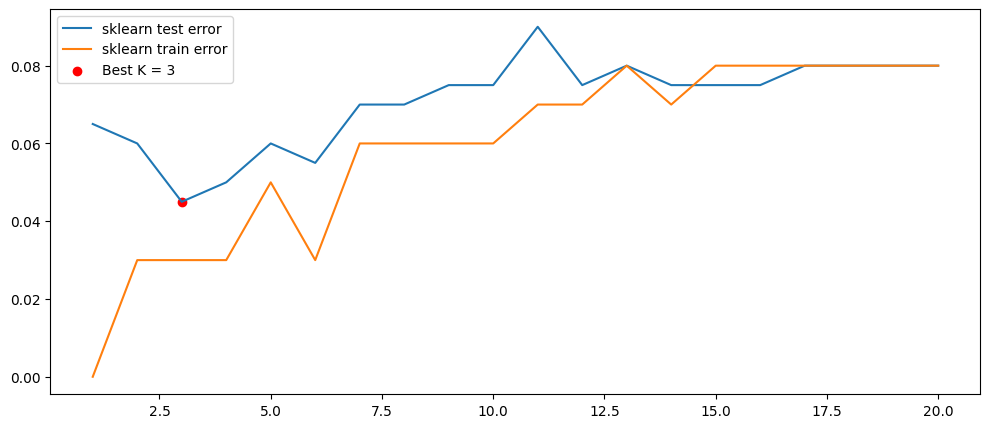

In [635]:
from sklearn.neighbors import KNeighborsClassifier
k_pos = np.arange(1,21)
error_train = np.zeros((len(k_pos)))
error_numpy = np.zeros((len(k_pos)))
error_test = np.zeros((len(k_pos)))
error_inf = np.inf
best_k_test = 1
def sklearn_knn (x_test,class_train,x_train,k) :
    knn_test = KNeighborsClassifier(k)
    knn_test.fit(x_train,class_train)
    class_pred_numpy = knn_test.predict(x_test)
    return class_pred_numpy

for k in k_pos : 
    class_pred_train = sklearn_knn (x_train,class_train, x_train, k)
    error_train[k-1] = np.mean(class_train.astype(int) != class_pred_train)

    class_pred_test = sklearn_knn(x_test,class_train,x_train,k)
    error_test[k-1] = np.mean(test[:,0].astype(int) != class_pred_test.astype(int))
    if error_test[k-1].astype(float) < error_inf : #trouver le k qui donne la plus petite erreur dans le test set
        error_inf = error_test[k-1].astype(float)
        best_k_test = k

plt.figure(figsize=(12,5))
plt.plot(k_pos,error_test,label= "sklearn test error")
plt.plot(k_pos,error_train,label= "sklearn train error")
plt.scatter(best_k_test,error_inf,color='r',label=f"Best K = {best_k_test}")

plt.legend()

In [636]:
print(f"The best K is: {best_k_test} with a test error rate of: {error_inf}")
"""on trouve les mêmes résultas, vérifions le runtime"""

The best K is: 3 with a test error rate of: 0.045


'on trouve les mêmes résultas, vérifions le runtime'

In [637]:
import timeit
time_sklearn = timeit.timeit(
    stmt="sklearn_knn(x_test, class_train, x_train, 5)",
    setup="from __main__ import sklearn_knn, x_train, x_test, class_train",
    number=50  # Run 10 times to get an average
)
print(f"Sklearn KNN runtime for K={k}: {time_sklearn:.4f} seconds")

# Timing custom KNN
time_custom = timeit.timeit(
    stmt="knn(x_test, class_train,x_train, 5)",
    setup="from __main__ import knn, x_train, x_test, class_train",
    number=50  # Run 10 times to get an average
)
print(f"Naive KNN runtime for K={k}: {time_custom:.4f} seconds")

Sklearn KNN runtime for K=20: 0.1296 seconds
Naive KNN runtime for K=20: 0.0688 seconds


In [638]:
naive_knn = timeit.timeit(lambda: knn(x_test,class_train,x_train,5),number=50)
skln_knn = timeit.timeit(lambda: sklearn_knn(x_test,class_train,x_train,5),number=50)

print(f"Sklearn KNN runtime for K=5: {skln_knn:.4f} seconds")
print(f"Naive KNN runtime for K=5: {naive_knn:.4f} seconds")

Sklearn KNN runtime for K=5: 0.1301 seconds
Naive KNN runtime for K=5: 0.0680 seconds


On remarque que le runtime de notre fonction knn est plus rapide (plus petite) que le sklearn knn.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

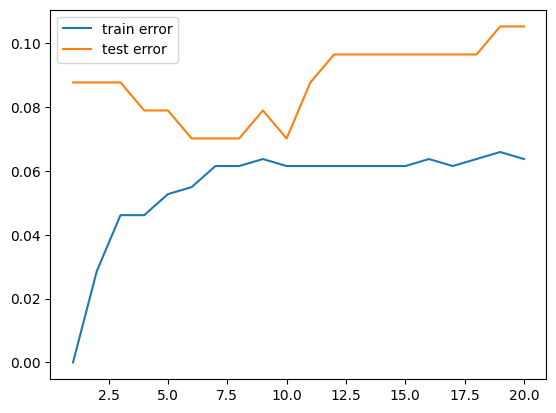

In [639]:
from sklearn.model_selection import train_test_split
data = np.loadtxt('data/wdbc12.data.txt',delimiter=',')
data = data[:,1:]
y = data[:,0]
X = data[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
train_error = np.zeros((len(k_pos)))
test_error = np.zeros((len(k_pos)))
for k in k_pos : 
    sklearn_knnn = KNeighborsClassifier(k)
    sklearn_knnn.fit(X_train,y_train)
    class_train_sklearn = sklearn_knnn.predict(X_train)

    # train_pred = knn(X_train,y_train,X_train,k)
    train_error[k-1] = np.mean(y_train != class_train_sklearn)
    # test_pred = knn(X_test,y_train,X_train,k)
    class_test_sklearn = sklearn_knnn.predict(X_test)
    test_error[k-1] = np.mean(y_test != class_test_sklearn)
plt.plot(k_pos, train_error,label="train error")
plt.plot(k_pos, test_error, label="test error")
plt.legend()


In [640]:
naive_knn = timeit.timeit(lambda: knn(X_train,y_train,X_train,5),number=50)
bn_knn = timeit.timeit(lambda: knn_bn(X_train,y_train,X_train,5),number=50)
skln_knn = timeit.timeit(lambda: sklearn_knn(X_train,y_train,X_train,5),number=50)

print(f"Sklearn KNN runtime for K=5: {skln_knn:.4f} seconds")
print(f"Bn KNN runtime for K=5: {bn_knn:.4f} seconds")
print(f"Naive KNN runtime for K=5: {naive_knn:.4f} seconds")

Sklearn KNN runtime for K=5: 0.0574 seconds
Bn KNN runtime for K=5: 0.3796 seconds
Naive KNN runtime for K=5: 0.6675 seconds


In [641]:
"""On peut voir qu'en manipulant des données volumineuses et réelles, sklearn est plus rapide.
Aussi, en comparant les deux fonctions créées, une utilisant argsort et l'aute bn.argpartition, on trouve que la deuxième est plus rapide."""

"On peut voir qu'en manipulant des données volumineuses et réelles, sklearn est plus rapide.\nAussi, en comparant les deux fonctions créées, une utilisant argsort et l'aute bn.argpartition, on trouve que la deuxième est plus rapide."

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [642]:
!cd example_cy && python setup.py build_ext --inplace

zsh:1: command not found: python


In [643]:
import example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [644]:
!cd example_np_cy && python3 setup.py build_ext --inplace

running build_ext


In [645]:
import example_np_cy.compute as toy
array1, array2 = np.array([[1,3],[3,5]]), np.array([[6,8],[3,4]])
toy.compute(array1,array2,2,3,4)

array([[26, 34],
       [19, 26]])

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [646]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [696]:
%%cython

import numpy as np
cimport numpy as np
from scipy.stats import mode
import timeit


# load the set 
train = np.loadtxt('data/synth_train.txt')
class_train = train[:,0]
x_train = train[:,1:]

test = np.loadtxt('data/synth_test.txt') 
x_test = test[:,1:]

DTYPE = np.intc

# Définir la fonction pour calculer la distance
cdef distance(double[:,:] x_train_view, Py_ssize_t N_train, double[:,:] x_test_view, Py_ssize_t i):
    cdef Py_ssize_t j, d
    cdef double dist, diff
    distances = np.zeros(N_train, dtype=float)
    cdef double[:] distances_view = distances
  
    for j in range(N_train):
        dist = 0
        for d in range(x_train_view.shape[1]):
            diff = x_train_view[j, d] - x_test_view[i, d]
            dist += diff * diff
        distances_view[j] = dist
    return distances_view

# Définir la fonction KNN

cdef cknn(double[:,:] x_test, np.ndarray class_train, double[:,:] x_train, int k):
    cdef Py_ssize_t N_test = x_test.shape[0]
    cdef Py_ssize_t N_train = x_train.shape[0]
    cdef Py_ssize_t i, idx
    cdef int mode_class

    class_test = np.zeros(N_test, dtype=DTYPE)
    cdef int[:] class_test_review = class_test
    cdef double[:,:] x_train_view = x_train
    cdef double[:,:] x_test_view = x_test

    for i in range(N_test):
        distances = distance(x_train_view, N_train, x_test_view, i)
        mode_class = int(mode(class_train[np.argsort(distances)[:k]])[0])
        class_test_review[i] = mode_class

    return class_test


# Appeler la fonction KNN
cresult = cknn(x_test, class_train, x_train, 5)
print(cresult)

execution_time = timeit.timeit(lambda: cknn(x_test, class_train, x_train, 5), number=100)
print(f"Temps d'exécution cython moyen sur 100 itérations : {execution_time / 10:.6f} secondes")

Content of stderr:
In file included from /Users/saadmhamdi/.cache/ipython/cython/_cython_magic_3602cf3fc4bddd6bfcdb7f5712810c00e54e39d3.c:1319:
In file included from /Users/saadmhamdi/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/arrayobject.h:5:
In file included from /Users/saadmhamdi/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12:
In file included from /Users/saadmhamdi/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1909:
/Users/saadmhamdi/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
/Users/saadmhamdi/.cache/ipython/cython/_cython_magic_3602cf3fc4bddd6bfcdb7f5712810c00e54e39d3.c:25153:26: warning: code will never be executed [-Wunreachabl

In [697]:
result = knn(x_test, class_train, x_train, 5)
print(result)

execution_time = timeit.timeit(lambda: knn(x_test, class_train, x_train, 5), number=100)
print(f"Temps d'exécution knn moyen sur 100 itérations : {execution_time / 10:.6f} secondes")

[2 2 2 2 2 2 2 2 2 1 2 1 2 2 1 2 2 1 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 1 2 2 1
 1 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2
 1 1 2 2 1 1 1 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 1 1 2 2 2
 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 1
 2 2 1 1 2 1 1 1 2 2 2 2 2 2 1]
Temps d'exécution knn moyen sur 100 itérations : 0.018274 secondes


In [701]:
import numpy as np
from scipy.stats import mode

def naive_knn(x_test, class_train, x_train, k):
    N_test = x_test.shape[0]
    N_train = x_train.shape[0]
    class_test = np.zeros(N_test, dtype=int)

    for i in range(N_test):
        distance_array = np.zeros(N_train, dtype=float)
        for j in range(N_train):
            total_diff = 0 
            for d in range(x_train.shape[1]):
                difference = x_train[j, d] - x_test[i, d]
                total_diff += difference ** 2
            distance_array[j] = total_diff

        # Identifier les indices des k plus proches voisins
        neighbor_indices = np.argsort(distance_array)[:k]

        # Extraire les classes des k plus proches voisins
        closest_classes = class_train[neighbor_indices]

        # Calculer la classe la plus courante parmi les voisins
        most_common_class = int(mode(closest_classes)[0])
        class_test[i] = most_common_class

    return class_test

execution_time = timeit.timeit(lambda: naive_knn(x_test, class_train, x_train, 5), number=100)
print(f"Temps d'exécution knn naïf moyen sur 100 itérations : {execution_time / 10:.6f} secondes")

Temps d'exécution knn naïf moyen sur 100 itérations : 0.279401 secondes


4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

Notre code Cython est environ deux fois plus rapide qu’un algorithme naïf en Python, principalement grâce à la compilation en C qui optimise les boucles et les calculs répétitifs. Cependant, il reste plus lent qu’un algorithme optimisé avec numpy, qui exploite des opérations vectorielles extrêmement efficaces en C, éliminant les boucles explicites et réduisant ainsi le temps d’exécution. En résumé, Cython améliore la performance par rapport à Python pur, mais n’égale pas les optimisations de numpy pour le traitement de tableaux.

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [650]:
# your code

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [651]:
# your code